In [1]:
import pandas as pd
from PIL import Image
import os
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, roc_auc_score
import torch
import numpy as np
from torchmetrics.classification import BinaryAUROC
from classification import *
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

/home/nhattm/.conda/envs/isic/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fold =1
df_data = pd.read_csv("./dataset/data_images.csv")
# get dataframe train and test
df_train = df_data[df_data["fold"] != fold].reset_index(drop=True)
df_test = df_data[df_data["fold"] == fold].reset_index(drop=True)
train_loader = ISIC_Loader(df_train)
test_loader = ISIC_Loader(df_test)
# Define data loaders for the training and test data
train_dataset = DataLoader(
    train_loader,
    batch_size=cfg.TRAIN.BATCH_SIZE,
    pin_memory=True,
    shuffle=True,
    num_workers=cfg.TRAIN.NUM_WORKERS,
    drop_last=True,
    prefetch_factor=cfg.TRAIN.PREFETCH_FACTOR,
)
test_dataset = DataLoader(
    test_loader,
    batch_size=cfg.TRAIN.BATCH_SIZE,
    num_workers=cfg.TRAIN.NUM_WORKERS,
    prefetch_factor=cfg.TRAIN.PREFETCH_FACTOR,
        )
model = convnext_small(
    pretrained=cfg.TRAIN.PRETRAIN,
    in_22k=cfg.TRAIN.CONVEXT.IN22K,
    in_chans=cfg.DATA.IN_CHANNEL,
    num_classes=cfg.DATA.NUM_CLASS,
    drop_path_rate=cfg.TRAIN.CONVEXT.DROPOUT,
)
classifier = Classifier(
    model,
    cfg.DATA.CLASS_WEIGHT,
    cfg.DATA.NUM_CLASS,
    cfg.OPT.LEARNING_RATE,
    cfg.OPT.FACTOR_LR,
    cfg.OPT.PATIENCE_LR,
)

In [5]:
# calculate the number of positvie and negative samples from the test set
len(df_train[df_train["target"] == 0]), len(df_train[df_train["target"] == 1])

(40000, 4399)

In [10]:
classifier.head1

AttributeError: 'Classifier' object has no attribute 'head1'

In [9]:
list(classifier.parameters())[-2]

Parameter containing:
tensor([[ 0.0049,  0.0229,  0.0235,  ..., -0.0358,  0.0226,  0.0296],
        [ 0.0014,  0.0314, -0.0123,  ..., -0.0010,  0.0047, -0.0274]],
       requires_grad=True)

In [6]:
for parameter in list(classifier.parameters())[:-4]:
    print(parameter)

Parameter containing:
tensor([[[[ 2.6024e-02, -4.8613e-02, -3.1641e-02, -2.6887e-02],
          [-4.0193e-02,  2.8517e-03,  1.7415e-02, -3.6041e-02],
          [ 7.9220e-02,  6.5498e-02, -6.0921e-02,  6.8836e-03],
          [ 2.8525e-02,  1.0340e-02,  5.3839e-02, -2.0126e-02]],

         [[-2.5040e-02,  2.7946e-02,  4.3075e-02,  6.0945e-02],
          [-2.5231e-02, -1.7994e-03,  6.3893e-02,  7.2836e-02],
          [-1.1637e-01, -6.5502e-02,  1.0862e-01, -5.7323e-02],
          [-5.9177e-02, -5.7063e-03, -1.2982e-01,  7.0224e-02]],

         [[ 4.5493e-02, -2.1283e-02, -3.1571e-02, -1.4147e-04],
          [-3.2134e-03, -2.7363e-02, -7.4524e-02, -2.3605e-02],
          [ 6.3039e-02,  3.7726e-02, -8.3411e-02,  4.5203e-02],
          [ 2.7618e-03,  1.1045e-02,  7.4261e-02,  1.2820e-02]]],


        [[[ 5.8604e-02,  1.9273e-02,  8.5888e-03,  4.3860e-02],
          [ 5.6624e-03,  3.2011e-02,  6.0022e-02,  7.2193e-02],
          [-1.1475e-01,  1.2901e-01,  1.8447e-01,  5.3808e-02],
          

In [11]:
image, label = next(iter(train_dataset))
image = image.to(device)
classifier.eval()
classifier = classifier.to(device)

In [18]:
y_pred1 = classifier(image).detach().cpu()[:, 1:2]
y_pred2 = classifier(image).detach().cpu()[:, 1:2]

In [27]:
y_pred = torch.cat((y_pred1, y_pred2), 0)
y_true = torch.cat((label, label), 0)

In [28]:
y_true.shape

torch.Size([4, 1])

In [25]:
y_pred.shape

torch.Size([4, 1])

In [29]:
partial_auc(y_pred, label)

tensor(-0.1600)

In [12]:
label.shape

torch.Size([2])

In [8]:
y_pred = classifier(image).detach().cpu()

f1_score_batch(label, y_pred)

tensor(9.9990e-05)

In [16]:
np.asarray(y_pred.detach().cpu()[:, 1])

array([0.42101938, 0.6100592 ], dtype=float32)

In [70]:
label.shape

torch.Size([2])

In [31]:
target = np.array([0, 1, 1, 0])
preds = np.array([0, 0.5, 0.7, 0.8])

In [33]:
partial_auc1(target, preds)

np.float64(0.09999999999999996)

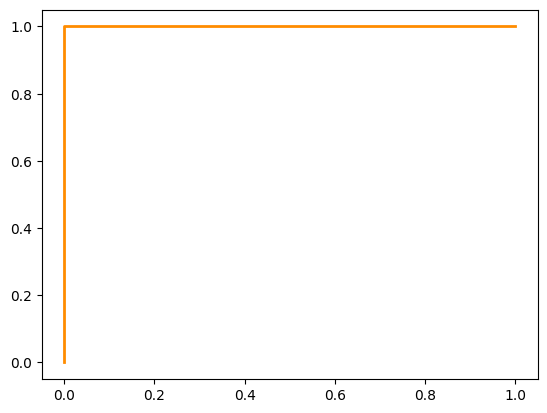

In [10]:
#draw ROC curve
roc_auc = auc(fpr, tpr)
aucs.append(roc_auc)
# use plt to draw
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

In [9]:
tpr

array([0., 1., 1.])

In [8]:
fpr

array([0., 0., 1.])